In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [3]:
credit = pd.read_csv("/Users/kwonheejin/Documents/DL/dataset/creditcard.csv")

In [4]:
credit

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
X_data = credit.iloc[:, 1:-1]
y_data = credit.iloc[:, -1]

# 표준화
scaler = StandardScaler()
scaler.fit(X_data)
X_train = scaler.transform(X_data)

# ====== 2) 오토 인코더 모델 학습 및 예측 ======
X_train_AE = X_train.copy()

# 파라미터 설정
n_input = X_train_AE.shape[1]
n_output = n_input

In [6]:
# 모델 레이어 설정
x_Input = Input(batch_shape=(None, n_input))
x_Encoder1 = Dense(256, activation='relu')(x_Input)
x_Encoder1 = Dropout(0.3)(x_Encoder1)
x_Encoder2 = Dense(512, activation='relu')(x_Encoder1)
x_Encoder2 = Dropout(0.2)(x_Encoder2)
y_Decoder1 = Dense(256, activation='relu')(x_Encoder2)
y_Decoder1 = Dropout(0.3)(y_Decoder1)
y_Decoder2 = Dense(n_output, activation='linear')(y_Decoder1)

In [9]:
# 모델 구조 설정
model = Model(x_Input, y_Decoder2)
model.compile(loss='mse', optimizer=Adam(lr=0.001))
print("====== 모델 전체 구조 ======")
print(model.summary())

# 모델 파라미터 및 조기 종료 조건
EPOCHS = int(input('학습 횟수 설정: '))
BATCH = int(input('배치 사이즈 설정: '))
es = EarlyStopping(monitor='loss', patience=5, verbose=1)

====== 모델 전체 구조 ======
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 256)               7680      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 

In [10]:
# 모델 훈련
hist = model.fit(X_train_AE, X_train_AE, 
                 epochs=EPOCHS,
                 batch_size=BATCH,
                 callbacks=[es],
                 shuffle=True)

Epoch 1/15
557/557 [==============================] - 3s 5ms/step - loss: 0.2419
Epoch 2/15
557/557 [==============================] - 3s 5ms/step - loss: 0.1620
Epoch 3/15
557/557 [==============================] - 3s 5ms/step - loss: 0.1484
Epoch 4/15
557/557 [==============================] - 3s 5ms/step - loss: 0.1412
Epoch 5/15
557/557 [==============================] - 3s 5ms/step - loss: 0.1321
Epoch 6/15
557/557 [==============================] - 3s 5ms/step - loss: 0.1301
Epoch 7/15
557/557 [==============================] - 3s 5ms/step - loss: 0.1276
Epoch 8/15
557/557 [==============================] - 3s 5ms/step - loss: 0.1236
Epoch 9/15
557/557 [==============================] - 3s 5ms/step - loss: 0.1248
Epoch 10/15
557/557 [==============================] - 3s 5ms/step - loss: 0.1258
Epoch 11/15
557/557 [==============================] - 3s 5ms/step - loss: 0.1210
Epoch 12/15
557/557 [==============================] - 3s 5ms/step - loss: 0.1193
Epoch 13/15
557/557 [====

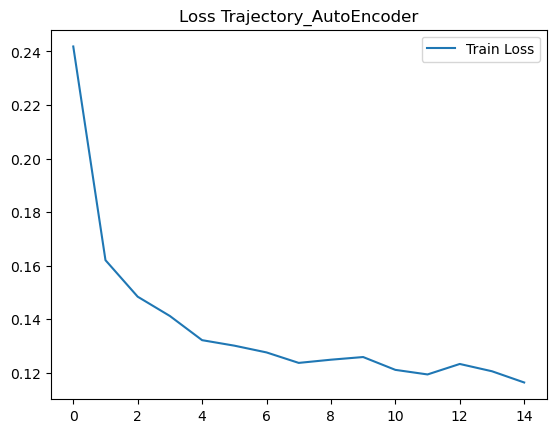

In [11]:
# loss 그래프
plt.plot(hist.history['loss'], label='Train Loss')
plt.title('Loss Trajectory_AutoEncoder')
plt.legend()
plt.show()

In [12]:
# 예측
y_pred_AE = model.predict(X_train_AE)

8901/8901 [==============================] - 3s 388us/step


In [13]:
# 거리 계산
def calc_distance(origin, pred):
    dist = []
    for i in range(len(pred)):
        dist.append(np.sqrt(np.sum(np.square(origin[i]-pred[i]))))
    return pd.Series(dist)

In [14]:
distance_AE = calc_distance(X_train_AE, y_pred_AE)

In [15]:
credit['distance_AE'] = distance_AE

In [16]:
from sklearn.ensemble import IsolationForest

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


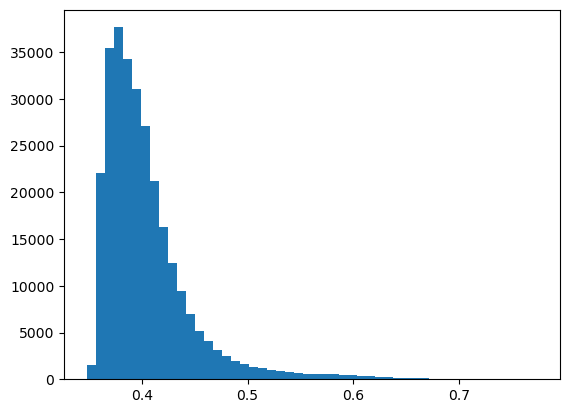

In [17]:
# ====== 3) IsolationForest 모델 학습 및 예측 ======
X_train_IF = X_train.copy()

model2 = IsolationForest(n_estimators=200, verbose=1)
model2.fit(X_train_IF)
score = abs(model2.score_samples(X_train_IF)) # 이상치 점수

plt.hist(score, bins=50) # 이상치 점수 시각화
plt.show()

y_pred_IF = (score > 0.7).astype(int) # 이상치 점수 기준: 0.7

credit['Class_iForest'] = pd.Series(y_pred_IF) # 원래 데이터에 넣기

In [18]:
# ====== 4) 결과 비교 ======
df = credit.sort_values(by='distance_AE', ascending=False) # 거리 순 정렬

print(df['Class'].value_counts()) # original label 이상치
print(df['Class_iForest'].value_counts()) # iForest label 이상치

0    284315
1       492
Name: Class, dtype: int64
0    284638
1       169
Name: Class_iForest, dtype: int64


In [19]:
# AE로 계산한 거리 상위 n개 중 이상치 몇 개 있는지 반환
def count_abnormal(data, threshold, num=30):
    for i in range(threshold//num):
        print(f"<< 상위 {(i+1)*num}개에서 이상치 체크 >> ")
        print("  ====== AutoEncoder vs. Original Label ======")
        print(data['Class'][:(i+1)*num].value_counts())        
        print("  ====== AutoEncoder vs. iForest Label ======")
        print(data['Class_iForest'][:(i+1)*num].value_counts())
        print(" ")

# 상위 600개 데이터에서 비교
count_abnormal(df, 600)

<< 상위 30개에서 이상치 체크 >> 
  ====== AutoEncoder vs. Original Label ======
1    23
0     7
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label ======
0    19
1    11
Name: Class_iForest, dtype: int64
 
<< 상위 60개에서 이상치 체크 >> 
  ====== AutoEncoder vs. Original Label ======
1    47
0    13
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label ======
0    41
1    19
Name: Class_iForest, dtype: int64
 
<< 상위 90개에서 이상치 체크 >> 
  ====== AutoEncoder vs. Original Label ======
1    72
0    18
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label ======
0    59
1    31
Name: Class_iForest, dtype: int64
 
<< 상위 120개에서 이상치 체크 >> 
  ====== AutoEncoder vs. Original Label ======
1    78
0    42
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label ======
0    82
1    38
Name: Class_iForest, dtype: int64
 
<< 상위 150개에서 이상치 체크 >> 
  ====== AutoEncoder vs. Original Label ======
1    91
0    59
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label ======


In [20]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics.pairwise import cosine_similarity

In [21]:
#EPOCHES = 300
EPOCHES = 10

df = pd.read_csv("/Users/kwonheejin/Documents/DL/dataset/creditcard.csv")
df.shape

dataX=df.iloc[:,1:-1]
dataX = (dataX- dataX.mean()) / dataX.std()
dt=np.array(dataX).astype(np.float32)

nFeature=dt.shape[1]
inputX = Input(batch_shape=(None,nFeature))
Xencode = Dense(12, activation='relu')(inputX)
Xdecode = Dense(nFeature, activation='linear')(Xencode)
model = Model(inputX, Xdecode)
model.compile(loss='mse', optimizer=Adam(lr=0.001))
h = model.fit(dt,dt,epochs=EPOCHES, batch_size=1000, shuffle=True)
yhat=model.predict(dt)

dist_list=[]
for i in range(len(yhat)):
    dist = cosine_similarity([dt[i]],[yhat[i]])
    dist_list.append(dist)

dist_list2 = dist_list.copy()
maxN=492
max_dict={}
for i in range(maxN):
    max_index = dist_list2.index(max(dist_list2))
    max_value = dist_list2.pop(max_index)
    dist_list2.insert(max_index,0)
    max_dict[max_index]=max_value

actual =set(df[df['Class']==1].index)
predicted = set(max_dict.keys())
print('실제로 비정상인 데이터 수:',len(actual))
print('실제 비정상인데 비정상으로 예측한 데이터 수:',len(actual.intersection(predicted)))
print('precision={}'.format(len(actual.intersection(predicted))/len(actual)))

Epoch 1/10
267/285 [===========================>..] - ETA: 0s - loss: 0.9857

/Users/kwonheejin/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


285/285 [==============================] - 0s 379us/step - loss: 0.9720
Epoch 2/10
285/285 [==============================] - 0s 379us/step - loss: 0.6898
Epoch 3/10
285/285 [==============================] - 0s 373us/step - loss: 0.6172
Epoch 4/10
285/285 [==============================] - 0s 377us/step - loss: 0.5889
Epoch 5/10
285/285 [==============================] - 0s 370us/step - loss: 0.5716
Epoch 6/10
285/285 [==============================] - 0s 370us/step - loss: 0.5620
Epoch 7/10
285/285 [==============================] - 0s 372us/step - loss: 0.5579
Epoch 8/10
285/285 [==============================] - 0s 372us/step - loss: 0.5562
Epoch 9/10
285/285 [==============================] - 0s 376us/step - loss: 0.5555
Epoch 10/10
8901/8901 [==============================] - 1s 165us/step
실제로 비정상인 데이터 수: 492
실제 비정상인데 비정상으로 예측한 데이터 수: 22
precision=0.044715447154471545
